# Doodle Recognition Model (PyTorch)

This notebook builds a deep learning model to recognize doodles from the QuickDraw dataset using PyTorch.

## Dataset Overview
- Images organized by category in `doodles/doodle/` directory
- CSV file with metadata: countrycode, drawing strokes, key_id, recognized flag, word (category), image_path
- Multiple categories (e.g., airplane, traffic light, cat, etc.)


In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from PIL import Image
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
warnings.filterwarnings('ignore')

# Setup multiprocessing for macOS
# Try to use 'fork' method which works better with Jupyter notebooks
# If fork is not available, we'll fall back to num_workers=0
try:
    if hasattr(multiprocessing, 'set_start_method'):
        # Check if we can use fork (works on macOS but deprecated in Big Sur+)
        try:
            multiprocessing.set_start_method('fork', force=True)
            USE_MULTIPROCESSING = True
            print("✓ Using 'fork' multiprocessing method for DataLoader workers")
        except (RuntimeError, ValueError):
            # Fork not available, try spawn with proper setup
            try:
                multiprocessing.set_start_method('spawn', force=True)
                USE_MULTIPROCESSING = True
                print("✓ Using 'spawn' multiprocessing method for DataLoader workers")
            except (RuntimeError, ValueError):
                USE_MULTIPROCESSING = False
                print("⚠ Multiprocessing not available, using single-threaded DataLoader")
    else:
        USE_MULTIPROCESSING = True
except Exception as e:
    USE_MULTIPROCESSING = False
    print(f"⚠ Could not setup multiprocessing: {e}")
    print("  Falling back to single-threaded DataLoader")

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    print("MPS (Apple Silicon) available: True")
else:
    print("Using CPU")


✓ Using 'fork' multiprocessing method for DataLoader workers
PyTorch version: 2.9.1
CUDA available: False
MPS (Apple Silicon) available: True


In [43]:
# Setup device (GPU/MPS/CPU)
def setup_device():
    """Setup device for training (CUDA/MPS/CPU)"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ Using MPS (Apple Silicon)")
    else:
        device = torch.device('cpu')
        print("⚠ Using CPU")
    return device

device = setup_device()


✓ Using MPS (Apple Silicon)


## 1. Data Exploration


In [44]:
# Load a sample of the CSV to understand structure
# Since the CSV is very large (464MB), we'll work with chunks or sample
data_path = 'doodles/master_doodle_dataframe.csv'
doodle_dir = Path('doodles/doodle')

# Check available categories
categories = [d.name for d in doodle_dir.iterdir() if d.is_dir()]
print(f"Total number of categories: {len(categories)}")
print(f"\nFirst 20 categories: {categories[:20]}")

# Count images per category (sample check)
category_counts = {}
for category in categories[:10]:  # Sample first 10 categories
    category_path = doodle_dir / category
    if category_path.exists():
        png_files = list(category_path.glob('*.png'))
        category_counts[category] = len(png_files)
        print(f"{category}: {len(png_files)} images")


Total number of categories: 340

First 20 categories: ['lollipop', 'apple', 'diamond', 'helmet', 'skull', 'lipstick', 'cat', 'rhinoceros', 'peanut', 'pond', 'ant', 'jacket', 'blueberry', 'microwave', 'tree', 'paintbrush', 'butterfly', 'crown', 'leaf', 'boomerang']
lollipop: 3000 images
apple: 3000 images
diamond: 3000 images
helmet: 3000 images
skull: 3000 images
lipstick: 3000 images
cat: 3000 images
rhinoceros: 3000 images
peanut: 3000 images
pond: 3000 images


In [45]:
# Load a small sample from CSV to understand structure
print("Loading sample data from CSV...")
df_sample = pd.read_csv(data_path, nrows=1000)
print(f"\nCSV Shape (sample): {df_sample.shape}")
print(f"\nColumns: {df_sample.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_sample.head())
print(f"\nUnique categories in sample: {df_sample['word'].nunique()}")
print(f"\nCategories: {df_sample['word'].unique()[:20]}")


Loading sample data from CSV...

CSV Shape (sample): (1000, 6)

Columns: ['countrycode', 'drawing', 'key_id', 'recognized', 'word', 'image_path']

First few rows:
  countrycode                                            drawing  \
0          RO  [[[0, 5, 3, 4, 10, 72, 82, 91, 99, 98, 87, 71,...   
1          US  [[[0, 255], [3, 4]], [[86, 73, 73, 76, 85, 130...   
2          ZA  [[[39, 33, 34, 39, 52, 61, 66, 65, 67, 71], [2...   
3          VN  [[[12, 9], [128, 255]], [[0, 23, 36, 37, 42, 5...   
4          HU  [[[9, 7, 0, 19, 49, 90, 96, 99, 93, 94, 62, 16...   

             key_id  recognized           word  \
0  5613582005829632        True  traffic light   
1  5769631006457856        True  traffic light   
2  4999795544424448        True  traffic light   
3  4878417906368512        True  traffic light   
4  5572841187573760        True  traffic light   

                                image_path  
0  data/traffic light/5613582005829632.png  
1  data/traffic light/576963100645785

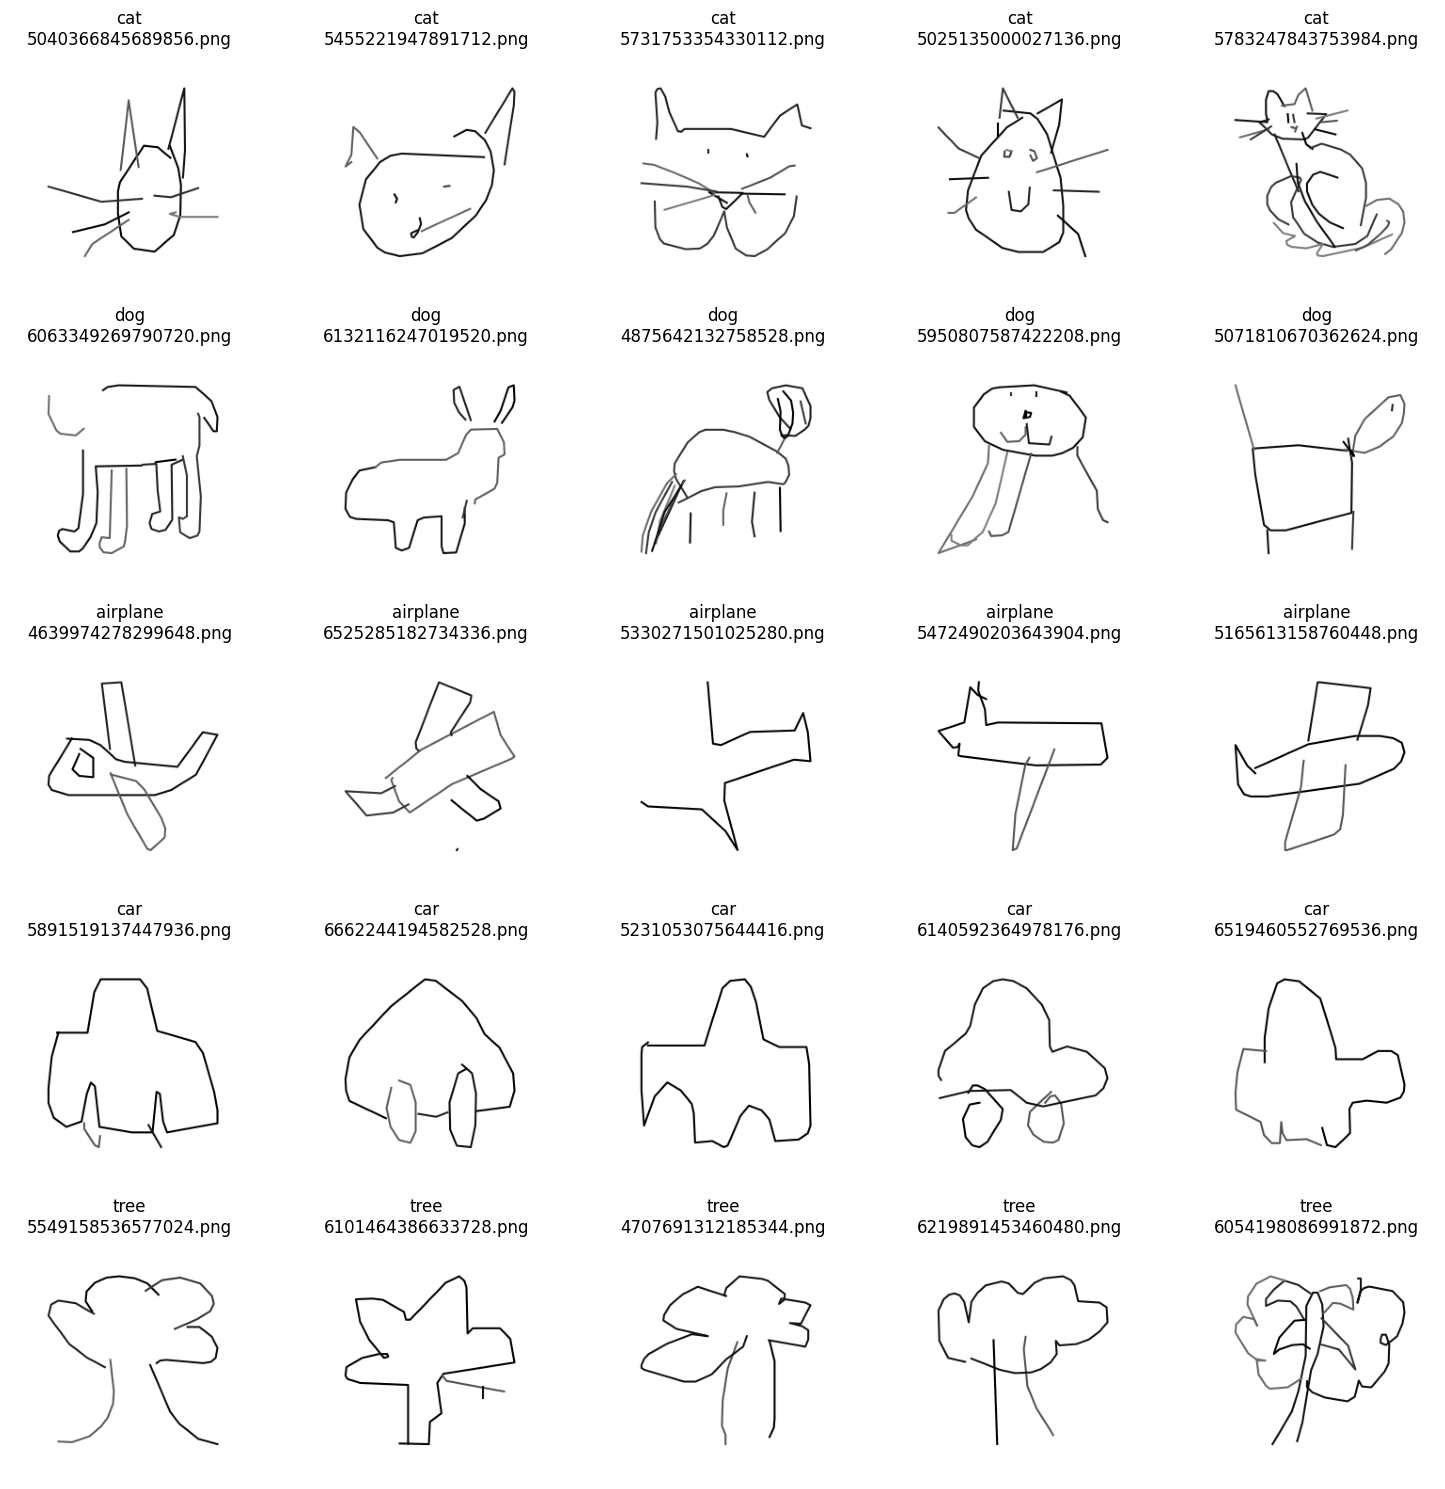

In [46]:
# Visualize sample images
def display_sample_images(categories_list, num_samples=5):
    """Display sample images from different categories"""
    fig, axes = plt.subplots(len(categories_list), num_samples, figsize=(15, 3*len(categories_list)))
    if len(categories_list) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, category in enumerate(categories_list[:5]):  # Limit to 5 categories for display
        category_path = doodle_dir / category
        if category_path.exists():
            png_files = list(category_path.glob('*.png'))[:num_samples]
            for j, img_path in enumerate(png_files):
                if j < num_samples:
                    img = Image.open(img_path)
                    axes[idx, j].imshow(img, cmap='gray')
                    axes[idx, j].set_title(f"{category}\n{img_path.name}")
                    axes[idx, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display samples from a few categories
sample_categories = ['cat', 'dog', 'airplane', 'car', 'tree']
display_sample_images(sample_categories, num_samples=5)


## 2. Data Preparation


In [47]:
# Configuration
# Use 224x224 for transfer learning (standard ImageNet size)
# Pre-trained models expect this size for optimal performance
IMG_SIZE = 160  # Resize images to 224x224 for transfer learning
BATCH_SIZE = 64  # Can increase to 64 or 128 if you have more GPU memory
NUM_CLASSES = None  # Will be determined from data
SELECTED_CATEGORIES = None  # None means use all categories, or specify a list like ['cat', 'dog', 'airplane']
MAX_NUM_CLASSES = None  # None means use all classes, or specify a number to limit classes (e.g., 10)

# PyTorch Dataset class
class DoodleDataset(Dataset):
    """PyTorch Dataset for doodle images"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image
        img = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Function to verify image and return path with label if valid
def verify_image_with_label(args):
    """Verify that an image can be opened and return path with label if valid"""
    img_path, label = args
    try:
        with Image.open(img_path) as img:
            img.verify()
        return str(img_path), label, True
    except Exception as e:
        return None, None, False

# Function to load image paths and labels from directory structure with multithreading
def load_image_paths_from_directory(base_dir, categories=None, max_per_category=None, num_workers=16):
    """
    Load image paths and labels from directory structure using multithreading
    
    Args:
        base_dir: Base directory containing category folders
        categories: List of categories to load (None = all)
        max_per_category: Maximum images per category (None = all)
        num_workers: Number of worker threads for parallel processing
    
    Returns:
        image_paths: list of image paths
        labels: list of labels (integers)
        label_to_idx: dictionary mapping label names to indices
        idx_to_label: dictionary mapping indices to label names
    """
    base_path = Path(base_dir)
    
    if categories is None:
        categories = [d.name for d in base_path.iterdir() if d.is_dir()]
    
    label_to_idx = {label: idx for idx, label in enumerate(sorted(categories))}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}
    
    print(f"Loading image paths from {len(categories)} categories using {num_workers} workers...")
    
    # Collect all image paths with their labels
    all_image_tasks = []
    
    for category in categories:
        category_path = base_path / category
        if not category_path.exists():
            continue
        
        png_files = list(category_path.glob('*.png'))
        if max_per_category:
            png_files = png_files[:max_per_category]
        
        print(f"  Queuing {len(png_files)} images from '{category}'...")
        
        # Add all images from this category to the task list
        for img_path in png_files:
            all_image_tasks.append((img_path, label_to_idx[category]))
    
    print(f"Processing {len(all_image_tasks)} images in parallel...")
    
    # Process all images in parallel
    image_paths = []
    labels = []
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Submit all verification tasks
        future_to_task = {executor.submit(verify_image_with_label, task): task for task in all_image_tasks}
        
        # Collect results as they complete
        completed = 0
        for future in as_completed(future_to_task):
            completed += 1
            if completed % 1000 == 0:
                print(f"    Processed {completed}/{len(all_image_tasks)} images...")
            
            try:
                path, label, is_valid = future.result()
                if is_valid:
                    image_paths.append(path)
                    labels.append(label)
            except Exception as e:
                pass  # Suppress individual errors for speed
    
    print(f"\nLoaded {len(image_paths)} valid image paths")
    print(f"Number of classes: {len(label_to_idx)}")
    
    return image_paths, labels, label_to_idx, idx_to_label

# Get available categories and limit if MAX_NUM_CLASSES is set
base_path = Path('doodles/doodle')
if SELECTED_CATEGORIES is None:
    available_categories = sorted([d.name for d in base_path.iterdir() if d.is_dir()])
    if MAX_NUM_CLASSES is not None and MAX_NUM_CLASSES > 0:
        available_categories = available_categories[:MAX_NUM_CLASSES]
        print(f"Limiting to first {MAX_NUM_CLASSES} classes: {available_categories}")
    categories_to_load = available_categories
else:
    categories_to_load = SELECTED_CATEGORIES
    if MAX_NUM_CLASSES is not None and MAX_NUM_CLASSES > 0:
        categories_to_load = categories_to_load[:MAX_NUM_CLASSES]
        print(f"Limiting to first {MAX_NUM_CLASSES} classes from SELECTED_CATEGORIES: {categories_to_load}")

# Load data paths (limiting to reasonable size for initial training)
print("Loading training data paths...")
image_paths, labels, label_to_idx, idx_to_label = load_image_paths_from_directory(
    'doodles/doodle',
    categories=categories_to_load,
    max_per_category=1000  # Limit to 1000 images per category for faster training
)

NUM_CLASSES = len(label_to_idx)
print(f"\nTotal classes: {NUM_CLASSES}")


Loading training data paths...
Loading image paths from 340 categories using 16 workers...
  Queuing 1000 images from 'The Eiffel Tower'...
  Queuing 1000 images from 'The Great Wall of China'...
  Queuing 1000 images from 'The Mona Lisa'...
  Queuing 1000 images from 'airplane'...
  Queuing 1000 images from 'alarm clock'...
  Queuing 1000 images from 'ambulance'...
  Queuing 1000 images from 'angel'...
  Queuing 1000 images from 'animal migration'...
  Queuing 1000 images from 'ant'...
  Queuing 1000 images from 'anvil'...
  Queuing 1000 images from 'apple'...
  Queuing 1000 images from 'arm'...
  Queuing 1000 images from 'asparagus'...
  Queuing 1000 images from 'axe'...
  Queuing 1000 images from 'backpack'...
  Queuing 1000 images from 'banana'...
  Queuing 1000 images from 'bandage'...
  Queuing 1000 images from 'barn'...
  Queuing 1000 images from 'baseball'...
  Queuing 1000 images from 'baseball bat'...
  Queuing 1000 images from 'basket'...
  Queuing 1000 images from 'basketba

In [48]:
# Split data into train, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Training set: {len(train_paths)} samples")
print(f"Validation set: {len(val_paths)} samples")
print(f"Test set: {len(test_paths)} samples")
print(f"Number of classes: {NUM_CLASSES}")

# Define transforms with ImageNet normalization (required for pre-trained models)
# ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Enhanced data augmentation for training (improves generalization)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),  # Slightly larger for random crop
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Increased rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)  # ImageNet normalization
])

# No augmentation for validation/test (only resize and normalize)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)  # ImageNet normalization
])

# Create datasets
train_dataset = DoodleDataset(train_paths, train_labels, transform=train_transform)
val_dataset = DoodleDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = DoodleDataset(test_paths, test_labels, transform=val_test_transform)

# Worker initialization function for multiprocessing
def worker_init_fn(worker_id):
    """Initialize worker process"""
    np.random.seed(42 + worker_id)
    torch.manual_seed(42 + worker_id)

# Determine number of workers
if USE_MULTIPROCESSING:
    # Use multiple workers - adjust based on your CPU cores
    # Using min(4, cpu_count) to avoid too many workers
    num_workers = min(8, multiprocessing.cpu_count())
    persistent_workers = True  # Keep workers alive between epochs for efficiency
    print(f"✓ Using {num_workers} DataLoader workers with persistent_workers={persistent_workers}")
else:
    num_workers = 0
    persistent_workers = False
    print("⚠ Using single-threaded DataLoader (num_workers=0)")

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=num_workers,
    persistent_workers=persistent_workers if num_workers > 0 else False,
    worker_init_fn=worker_init_fn if num_workers > 0 else None,
    pin_memory=True if torch.cuda.is_available() or (hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()) else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=num_workers,
    persistent_workers=persistent_workers if num_workers > 0 else False,
    worker_init_fn=worker_init_fn if num_workers > 0 else None,
    pin_memory=True if torch.cuda.is_available() or (hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()) else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=num_workers,
    persistent_workers=persistent_workers if num_workers > 0 else False,
    worker_init_fn=worker_init_fn if num_workers > 0 else None,
    pin_memory=True if torch.cuda.is_available() or (hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()) else False
)


Training set: 238000 samples
Validation set: 51000 samples
Test set: 51000 samples
Number of classes: 340
✓ Using 8 DataLoader workers with persistent_workers=True


## 3. Model Architecture

Using transfer learning with pre-trained ResNet/EfficientNet models for better accuracy.


In [49]:
# Improved model using transfer learning with pre-trained ResNet18
# ResNet18 is proven to work well for image classification tasks and is faster than larger models
import torchvision.models as models

def create_resnet_model(num_classes, pretrained=True, freeze_backbone=False):
    """
    Create a ResNet18 model with transfer learning
    
    Args:
        num_classes: Number of output classes
        pretrained: Use ImageNet pre-trained weights
        freeze_backbone: Freeze backbone layers (only train classifier)
    
    Returns:
        Model ready for training
    """
    # Load pre-trained ResNet18
    model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
    
    # Freeze backbone if specified (useful for fine-tuning)
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    
    return model

def create_efficientnet_model(num_classes, pretrained=True, model_name='efficientnet_b0'):
    """
    Create an EfficientNet model with transfer learning
    EfficientNet provides better accuracy with fewer parameters
    
    Args:
        num_classes: Number of output classes
        pretrained: Use ImageNet pre-trained weights
        model_name: EfficientNet variant (b0-b7, b0 is fastest)
    
    Returns:
        Model ready for training
    """
    try:
        # Try to use timm library for EfficientNet (more flexible)
        import timm
        model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
        print(f"✓ Using timm library for {model_name}")
        return model
    except ImportError:
        print("⚠ timm not available, using torchvision EfficientNet")
        # Fallback to torchvision EfficientNet
        if model_name == 'efficientnet_b0':
            model = models.efficientnet_b0(weights='IMAGENET1K_V1' if pretrained else None)
        elif model_name == 'efficientnet_b1':
            model = models.efficientnet_b1(weights='IMAGENET1K_V1' if pretrained else None)
        else:
            model = models.efficientnet_b0(weights='IMAGENET1K_V1' if pretrained else None)
        
        # Replace classifier
        num_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        return model

# Choose model architecture
# Options: 'resnet18', 'efficientnet_b0', 'efficientnet_b1'
MODEL_ARCHITECTURE = 'resnet18'  # Change to 'efficientnet_b0' for better accuracy (slower)

# Two-stage training approach:
# Stage 1: Freeze backbone, train only classifier (faster, stabilizes classifier)
# Stage 2: Unfreeze backbone, fine-tune everything (better accuracy)
USE_TWO_STAGE_TRAINING = True  # Set to False to train everything from start

if MODEL_ARCHITECTURE == 'resnet18':
    # Start with frozen backbone for stage 1 training
    model = create_resnet_model(NUM_CLASSES, pretrained=True, freeze_backbone=USE_TWO_STAGE_TRAINING)
    print("✓ Created ResNet18 model with transfer learning")
    if USE_TWO_STAGE_TRAINING:
        print("  → Backbone is FROZEN (Stage 1: training classifier only)")
elif MODEL_ARCHITECTURE.startswith('efficientnet'):
    model = create_efficientnet_model(NUM_CLASSES, pretrained=True, model_name=MODEL_ARCHITECTURE)
    print(f"✓ Created {MODEL_ARCHITECTURE} model with transfer learning")
    if USE_TWO_STAGE_TRAINING:
        # Manually freeze EfficientNet backbone
        for name, param in model.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
        print("  → Backbone is FROZEN (Stage 1: training classifier only)")
else:
    print(f"⚠ Unknown architecture {MODEL_ARCHITECTURE}, using ResNet18")
    model = create_resnet_model(NUM_CLASSES, pretrained=True, freeze_backbone=USE_TWO_STAGE_TRAINING)

model = model.to(device)

# Display model architecture
print(f"\nModel: {MODEL_ARCHITECTURE}")
print(f"Device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


✓ Created ResNet18 model with transfer learning
  → Backbone is FROZEN (Stage 1: training classifier only)

Model: resnet18
Device: mps

Total parameters: 11,614,612
Trainable parameters: 438,100


## 4. Training Setup

Training configuration optimized for transfer learning with pre-trained models.


In [50]:
# Two-Stage Training Setup for Transfer Learning
# Stage 1: Train classifier only (backbone frozen)
# Stage 2: Fine-tune everything (backbone unfrozen)

# Loss function with label smoothing (helps with generalization)
LABEL_SMOOTHING = 0.1  # Reduces overconfidence, improves generalization
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

# Separate parameters for backbone and classifier
backbone_params = []
classifier_params = []

for name, param in model.named_parameters():
    if 'fc' in name or 'classifier' in name:
        classifier_params.append(param)
    else:
        backbone_params.append(param)

# Stage 1: Only train classifier (backbone is frozen)
# Use higher learning rate since we're training from scratch
optimizer_stage1 = optim.AdamW(
    classifier_params,  # Only classifier parameters
    lr=1e-3,  # Higher LR for new classifier
    weight_decay=0.01
)

scheduler_stage1 = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_stage1, T_0=5, T_mult=2, eta_min=1e-6
)

# Stage 2: Fine-tune everything (will be created after stage 1)
# Lower LR for pre-trained backbone, slightly lower for classifier
optimizer_stage2 = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-4},      # Lower LR for pre-trained backbone
    {'params': classifier_params, 'lr': 5e-4}     # Lower LR for classifier (already trained)
], weight_decay=0.01)

scheduler_stage2 = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_stage2, T_0=10, T_mult=2, eta_min=1e-6
)

# Training configuration
STAGE1_EPOCHS = 10  # Train classifier for 10 epochs
STAGE2_EPOCHS = 30  # Fine-tune everything for 30 epochs

print(f"✓ Two-stage training enabled")
print(f"  Stage 1: {STAGE1_EPOCHS} epochs - Classifier only (LR: 1e-3)")
print(f"  Stage 2: {STAGE2_EPOCHS} epochs - Full fine-tuning (Backbone LR: 1e-4, Classifier LR: 5e-4)")
print(f"✓ Using label smoothing: {LABEL_SMOOTHING}")
print(f"✓ Weight decay: 0.01")

# Start with stage 1 optimizer
optimizer = optimizer_stage1
scheduler = scheduler_stage1
current_stage = 1

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Best model tracking
best_val_acc = 0.0
best_model_state = None


✓ Two-stage training enabled
  Stage 1: 10 epochs - Classifier only (LR: 1e-3)
  Stage 2: 30 epochs - Full fine-tuning (Backbone LR: 1e-4, Classifier LR: 5e-4)
✓ Using label smoothing: 0.1
✓ Weight decay: 0.01


## 5. Training


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device, epoch=None, total_epochs=None):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Create progress bar
    epoch_prefix = f"Epoch {epoch}/{total_epochs}" if epoch is not None else "Training"
    pbar = tqdm(loader, desc=f"{epoch_prefix} [Train]", unit="batch", leave=False)
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        batch_total = labels.size(0)
        batch_correct = (predicted == labels).sum().item()
        total += batch_total
        correct += batch_correct
        
        # Update progress bar
        current_loss = running_loss / (batch_idx + 1)
        current_acc = correct / total
        pbar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.4f}',
            'batch_acc': f'{batch_correct}/{batch_total}'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device, epoch=None, total_epochs=None):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Create progress bar
    epoch_prefix = f"Epoch {epoch}/{total_epochs}" if epoch is not None else "Validating"
    pbar = tqdm(loader, desc=f"{epoch_prefix} [Val]", unit="batch", leave=False)
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            batch_total = labels.size(0)
            batch_correct = (predicted == labels).sum().item()
            total += batch_total
            correct += batch_correct
            
            # Update progress bar
            current_loss = running_loss / (batch_idx + 1)
            current_acc = correct / total
            pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.4f}',
                'batch_acc': f'{batch_correct}/{batch_total}'
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop with two-stage approach
TOTAL_EPOCHS = STAGE1_EPOCHS + STAGE2_EPOCHS if USE_TWO_STAGE_TRAINING else 50
patience = 15  # Increased patience for two-stage training
patience_counter = 0
epoch_count = 0

print(f"Starting {'two-stage' if USE_TWO_STAGE_TRAINING else 'single-stage'} training...")
print(f"Device: {device}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
if USE_TWO_STAGE_TRAINING:
    print(f"Total epochs: {TOTAL_EPOCHS} (Stage 1: {STAGE1_EPOCHS}, Stage 2: {STAGE2_EPOCHS})")
else:
    print(f"Total epochs: {TOTAL_EPOCHS}")

# Verify scheduler type
if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
    print("⚠ WARNING: Using ReduceLROnPlateau scheduler (legacy)")
    print("⚠ Make sure you've run the improved training setup cell (Cell 15)")
    print("⚠ The training loop will handle this, but two-stage training won't work correctly")
elif isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts):
    print("✓ Using CosineAnnealingWarmRestarts scheduler (correct)")
else:
    print(f"ℹ Using scheduler: {type(scheduler).__name__}")

print("-" * 60)

for epoch in range(TOTAL_EPOCHS):
    epoch_count += 1
    
    # Check if we need to switch to stage 2
    if USE_TWO_STAGE_TRAINING and epoch == STAGE1_EPOCHS:
        print("\n" + "=" * 60)
        print("STAGE 1 COMPLETE - Switching to Stage 2 (Fine-tuning)")
        print("=" * 60)
        
        # Unfreeze backbone
        for param in model.parameters():
            param.requires_grad = True
        
        # Switch to stage 2 optimizer and scheduler
        optimizer = optimizer_stage2
        scheduler = scheduler_stage2
        
        # Reset patience for stage 2
        patience_counter = 0
        print("✓ Backbone UNFROZEN - All parameters trainable")
        print(f"✓ Switched to Stage 2 optimizer (Backbone LR: 1e-4, Classifier LR: 5e-4)")
        print("=" * 60 + "\n")
    
    # Determine current stage for display
    if USE_TWO_STAGE_TRAINING:
        if epoch < STAGE1_EPOCHS:
            current_stage = 1
            stage_info = f"[Stage 1: Classifier Only]"
        else:
            current_stage = 2
            stage_info = f"[Stage 2: Fine-tuning]"
    else:
        stage_info = ""
    
    # Train with progress bar
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, 
                                         epoch=epoch+1, total_epochs=TOTAL_EPOCHS)
    
    # Validate with progress bar
    val_loss, val_acc = validate(model, val_loader, criterion, device, 
                                  epoch=epoch+1, total_epochs=TOTAL_EPOCHS)
    
    # Update learning rate (handle both scheduler types)
    if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(val_loss)  # ReduceLROnPlateau needs validation loss
    else:
        scheduler.step()  # Other schedulers (CosineAnnealingWarmRestarts) don't need val_loss
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        torch.save(best_model_state, 'best_doodle_model_pytorch.pth')
        patience_counter = 0
    
    # Print epoch summary
    status = "✓ BEST" if is_best else f"  (patience: {patience_counter}/{patience})"
    print(f"\nEpoch {epoch+1}/{TOTAL_EPOCHS} {stage_info} {status}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    lr_info = optimizer.param_groups[0]['lr']
    if len(optimizer.param_groups) > 1:
        lr_info = f"Backbone: {optimizer.param_groups[0]['lr']:.6f}, Classifier: {optimizer.param_groups[1]['lr']:.6f}"
    print(f"  Learning Rate: {lr_info}")
    if is_best:
        print(f"  → Model saved!")
    
    # Early stopping
    if not is_best:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
            break
    
    print("-" * 60)

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with validation accuracy: {best_val_acc:.4f}")


Starting two-stage training...
Device: mps
Batch size: 64
Training samples: 238000
Validation samples: 51000
Total epochs: 40 (Stage 1: 10, Stage 2: 30)
✓ Using CosineAnnealingWarmRestarts scheduler (correct)
------------------------------------------------------------



Epoch 1/40 [Stage 1: Classifier Only] ✓ BEST
  Train Loss: 4.5840 | Train Acc: 0.1324
  Val Loss:   4.1184 | Val Acc:   0.2249
  Learning Rate: 0.0009046039886902864
  → Model saved!
------------------------------------------------------------



Epoch 2/40 [Stage 1: Classifier Only] ✓ BEST
  Train Loss: 4.3348 | Train Acc: 0.1691
  Val Loss:   4.1005 | Val Acc:   0.2413
  Learning Rate: 0.0006548539886902864
  → Model saved!
------------------------------------------------------------



Epoch 3/40 [Stage 1: Classifier Only] ✓ BEST
  Train Loss: 4.2629 | Train Acc: 0.1801
  Val Loss:   4.0218 | Val Acc:   0.2572
  Learning Rate: 0.0003461460113097139
  → Model saved!
------------------------------------------------------------



Epoch 4/40 [Stage 1: Classifier Only] ✓ BEST
  Train Loss: 4.2147 | Train Acc: 0.1888
  Val Loss:   3.9756 | Val Acc:   0.2688
  Learning Rate: 9.639601130971382e-05
  → Model saved!
------------------------------------------------------------



Epoch 5/40 [Stage 1: Classifier Only] ✓ BEST
  Train Loss: 4.1807 | Train Acc: 0.1956
  Val Loss:   3.9699 | Val Acc:   0.2708
  Learning Rate: 0.001
  → Model saved!
------------------------------------------------------------



Epoch 6/40 [Stage 1: Classifier Only]   (patience: 0/15)
  Train Loss: 4.2369 | Train Acc: 0.1852
  Val Loss:   4.0245 | Val Acc:   0.2616
  Learning Rate: 0.0009755527298894294
------------------------------------------------------------



Epoch 7/40 [Stage 1: Classifier Only]   (patience: 1/15)
  Train Loss: 4.2300 | Train Acc: 0.1862
  Val Loss:   4.0354 | Val Acc:   0.2656
  Learning Rate: 0.0009046039886902864
------------------------------------------------------------



Epoch 8/40 [Stage 1: Classifier Only]   (patience: 2/15)
  Train Loss: 4.2099 | Train Acc: 0.1894
  Val Loss:   4.0000 | Val Acc:   0.2674
  Learning Rate: 0.0007940987335200904
------------------------------------------------------------



Epoch 9/40 [Stage 1: Classifier Only] ✓ BEST
  Train Loss: 4.1905 | Train Acc: 0.1934
  Val Loss:   4.0015 | Val Acc:   0.2732
  Learning Rate: 0.0006548539886902864
  → Model saved!
------------------------------------------------------------



Epoch 10/40 [Stage 1: Classifier Only] ✓ BEST
  Train Loss: 4.1690 | Train Acc: 0.1957
  Val Loss:   3.9573 | Val Acc:   0.2833
  Learning Rate: 0.0005005000000000001
  → Model saved!
------------------------------------------------------------

STAGE 1 COMPLETE - Switching to Stage 2 (Fine-tuning)
✓ Backbone UNFROZEN - All parameters trainable
✓ Switched to Stage 2 optimizer (Backbone LR: 1e-4, Classifier LR: 5e-4)




Epoch 11/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 2.8416 | Train Acc: 0.4800
  Val Loss:   2.3311 | Val Acc:   0.6037
  Learning Rate: Backbone: 0.000098, Classifier: 0.000488
  → Model saved!
------------------------------------------------------------



Epoch 12/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 2.4580 | Train Acc: 0.5751
  Val Loss:   2.1286 | Val Acc:   0.6525
  Learning Rate: Backbone: 0.000091, Classifier: 0.000452
  → Model saved!
------------------------------------------------------------



Epoch 13/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 2.2988 | Train Acc: 0.6169
  Val Loss:   2.0285 | Val Acc:   0.6752
  Learning Rate: Backbone: 0.000080, Classifier: 0.000397
  → Model saved!
------------------------------------------------------------



Epoch 14/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 2.1889 | Train Acc: 0.6446
  Val Loss:   1.9709 | Val Acc:   0.6891
  Learning Rate: Backbone: 0.000066, Classifier: 0.000328
  → Model saved!
------------------------------------------------------------



Epoch 15/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 2.1048 | Train Acc: 0.6671
  Val Loss:   1.9195 | Val Acc:   0.7020
  Learning Rate: Backbone: 0.000051, Classifier: 0.000251
  → Model saved!
------------------------------------------------------------



Epoch 16/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 2.0348 | Train Acc: 0.6861
  Val Loss:   1.8777 | Val Acc:   0.7131
  Learning Rate: Backbone: 0.000035, Classifier: 0.000173
  → Model saved!
------------------------------------------------------------



Epoch 17/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.9740 | Train Acc: 0.7034
  Val Loss:   1.8536 | Val Acc:   0.7190
  Learning Rate: Backbone: 0.000021, Classifier: 0.000104
  → Model saved!
------------------------------------------------------------



Epoch 18/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.9260 | Train Acc: 0.7165
  Val Loss:   1.8334 | Val Acc:   0.7243
  Learning Rate: Backbone: 0.000010, Classifier: 0.000049
  → Model saved!
------------------------------------------------------------



Epoch 19/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.8937 | Train Acc: 0.7265
  Val Loss:   1.8171 | Val Acc:   0.7298
  Learning Rate: Backbone: 0.000003, Classifier: 0.000013
  → Model saved!
------------------------------------------------------------



Epoch 20/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.8721 | Train Acc: 0.7322
  Val Loss:   1.8129 | Val Acc:   0.7325
  Learning Rate: Backbone: 0.000100, Classifier: 0.000500
  → Model saved!
------------------------------------------------------------



Epoch 21/40 [Stage 2: Fine-tuning]   (patience: 0/15)
  Train Loss: 2.0197 | Train Acc: 0.6883
  Val Loss:   1.8954 | Val Acc:   0.7065
  Learning Rate: Backbone: 0.000099, Classifier: 0.000497
------------------------------------------------------------



Epoch 22/40 [Stage 2: Fine-tuning]   (patience: 1/15)
  Train Loss: 1.9989 | Train Acc: 0.6938
  Val Loss:   1.8801 | Val Acc:   0.7089
  Learning Rate: Backbone: 0.000098, Classifier: 0.000488
------------------------------------------------------------



Epoch 23/40 [Stage 2: Fine-tuning]   (patience: 2/15)
  Train Loss: 1.9635 | Train Acc: 0.7032
  Val Loss:   1.8613 | Val Acc:   0.7128
  Learning Rate: Backbone: 0.000095, Classifier: 0.000473
------------------------------------------------------------



Epoch 24/40 [Stage 2: Fine-tuning]   (patience: 3/15)
  Train Loss: 1.9262 | Train Acc: 0.7139
  Val Loss:   1.8531 | Val Acc:   0.7166
  Learning Rate: Backbone: 0.000091, Classifier: 0.000452
------------------------------------------------------------



Epoch 25/40 [Stage 2: Fine-tuning]   (patience: 4/15)
  Train Loss: 1.8961 | Train Acc: 0.7215
  Val Loss:   1.8327 | Val Acc:   0.7234
  Learning Rate: Backbone: 0.000086, Classifier: 0.000427
------------------------------------------------------------



Epoch 26/40 [Stage 2: Fine-tuning]   (patience: 5/15)
  Train Loss: 1.8606 | Train Acc: 0.7327
  Val Loss:   1.8221 | Val Acc:   0.7263
  Learning Rate: Backbone: 0.000080, Classifier: 0.000397
------------------------------------------------------------



Epoch 27/40 [Stage 2: Fine-tuning]   (patience: 6/15)
  Train Loss: 1.8260 | Train Acc: 0.7422
  Val Loss:   1.8054 | Val Acc:   0.7299
  Learning Rate: Backbone: 0.000073, Classifier: 0.000364
------------------------------------------------------------



Epoch 28/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.7975 | Train Acc: 0.7497
  Val Loss:   1.7979 | Val Acc:   0.7331
  Learning Rate: Backbone: 0.000066, Classifier: 0.000328
  → Model saved!
------------------------------------------------------------



Epoch 29/40 [Stage 2: Fine-tuning]   (patience: 0/15)
  Train Loss: 1.7651 | Train Acc: 0.7593
  Val Loss:   1.8001 | Val Acc:   0.7315
  Learning Rate: Backbone: 0.000058, Classifier: 0.000290
------------------------------------------------------------



Epoch 30/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.7388 | Train Acc: 0.7666
  Val Loss:   1.7819 | Val Acc:   0.7357
  Learning Rate: Backbone: 0.000051, Classifier: 0.000251
  → Model saved!
------------------------------------------------------------



Epoch 31/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.7067 | Train Acc: 0.7769
  Val Loss:   1.7699 | Val Acc:   0.7405
  Learning Rate: Backbone: 0.000043, Classifier: 0.000211
  → Model saved!
------------------------------------------------------------



Epoch 32/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.6791 | Train Acc: 0.7851
  Val Loss:   1.7726 | Val Acc:   0.7414
  Learning Rate: Backbone: 0.000035, Classifier: 0.000173
  → Model saved!
------------------------------------------------------------



Epoch 33/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.6550 | Train Acc: 0.7927
  Val Loss:   1.7690 | Val Acc:   0.7428
  Learning Rate: Backbone: 0.000028, Classifier: 0.000137
  → Model saved!
------------------------------------------------------------



Epoch 34/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.6316 | Train Acc: 0.7994
  Val Loss:   1.7580 | Val Acc:   0.7458
  Learning Rate: Backbone: 0.000021, Classifier: 0.000104
  → Model saved!
------------------------------------------------------------



Epoch 35/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.6107 | Train Acc: 0.8057
  Val Loss:   1.7605 | Val Acc:   0.7463
  Learning Rate: Backbone: 0.000015, Classifier: 0.000074
  → Model saved!
------------------------------------------------------------



Epoch 36/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.5929 | Train Acc: 0.8110
  Val Loss:   1.7565 | Val Acc:   0.7468
  Learning Rate: Backbone: 0.000010, Classifier: 0.000049
  → Model saved!
------------------------------------------------------------



Epoch 37/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.5785 | Train Acc: 0.8160
  Val Loss:   1.7550 | Val Acc:   0.7475
  Learning Rate: Backbone: 0.000006, Classifier: 0.000028
  → Model saved!
------------------------------------------------------------



Epoch 38/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.5672 | Train Acc: 0.8199
  Val Loss:   1.7502 | Val Acc:   0.7493
  Learning Rate: Backbone: 0.000003, Classifier: 0.000013
  → Model saved!
------------------------------------------------------------



Epoch 39/40 [Stage 2: Fine-tuning] ✓ BEST
  Train Loss: 1.5596 | Train Acc: 0.8225
  Val Loss:   1.7494 | Val Acc:   0.7497
  Learning Rate: Backbone: 0.000002, Classifier: 0.000004
  → Model saved!
------------------------------------------------------------



Epoch 40/40 [Stage 2: Fine-tuning]   (patience: 0/15)
  Train Loss: 1.5552 | Train Acc: 0.8241
  Val Loss:   1.7525 | Val Acc:   0.7490
  Learning Rate: Backbone: 0.000100, Classifier: 0.000500
------------------------------------------------------------

Loaded best model with validation accuracy: 0.7497


## 6. Training History Visualization


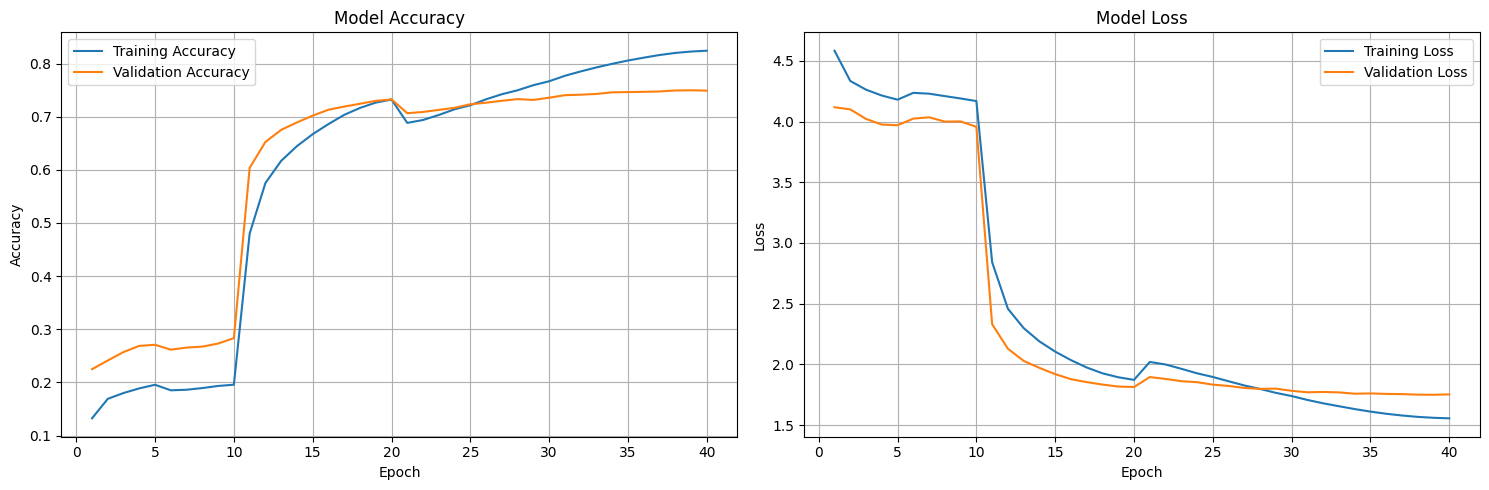

In [52]:
# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_acc']) + 1)
    
    # Accuracy plot
    axes[0].plot(epochs, history['train_acc'], label='Training Accuracy')
    axes[0].plot(epochs, history['val_acc'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(epochs, history['train_loss'], label='Training Loss')
    axes[1].plot(epochs, history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


## 7. Model Evaluation


In [53]:
# Evaluate on test set
def evaluate_test(model, loader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    correct_top3 = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Top-3 accuracy
            _, top3_preds = torch.topk(outputs, 3, dim=1)
            correct_top3 += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = running_loss / len(loader)
    test_acc = correct / total
    test_top3_acc = correct_top3 / total
    
    return test_loss, test_acc, test_top3_acc, all_preds, all_labels

print("Evaluating on test set...")
test_loss, test_accuracy, test_top3_accuracy, y_pred_classes, y_true_classes = evaluate_test(
    model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Top-3 Accuracy: {test_top3_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=[idx_to_label[i] for i in range(NUM_CLASSES)]
))


Evaluating on test set...

Test Loss: 1.7541
Test Accuracy: 0.7503
Test Top-3 Accuracy: 0.9070

Classification Report:
                         precision    recall  f1-score   support

       The Eiffel Tower       0.89      0.91      0.90       150
The Great Wall of China       0.62      0.49      0.55       150
          The Mona Lisa       0.90      0.89      0.90       150
               airplane       0.82      0.88      0.85       150
            alarm clock       0.86      0.91      0.89       150
              ambulance       0.79      0.70      0.74       150
                  angel       0.92      0.97      0.94       150
       animal migration       0.71      0.84      0.77       150
                    ant       0.82      0.93      0.88       150
                  anvil       0.76      0.77      0.77       150
                  apple       0.86      0.87      0.86       150
                    arm       0.75      0.71      0.73       150
              asparagus       0.76 

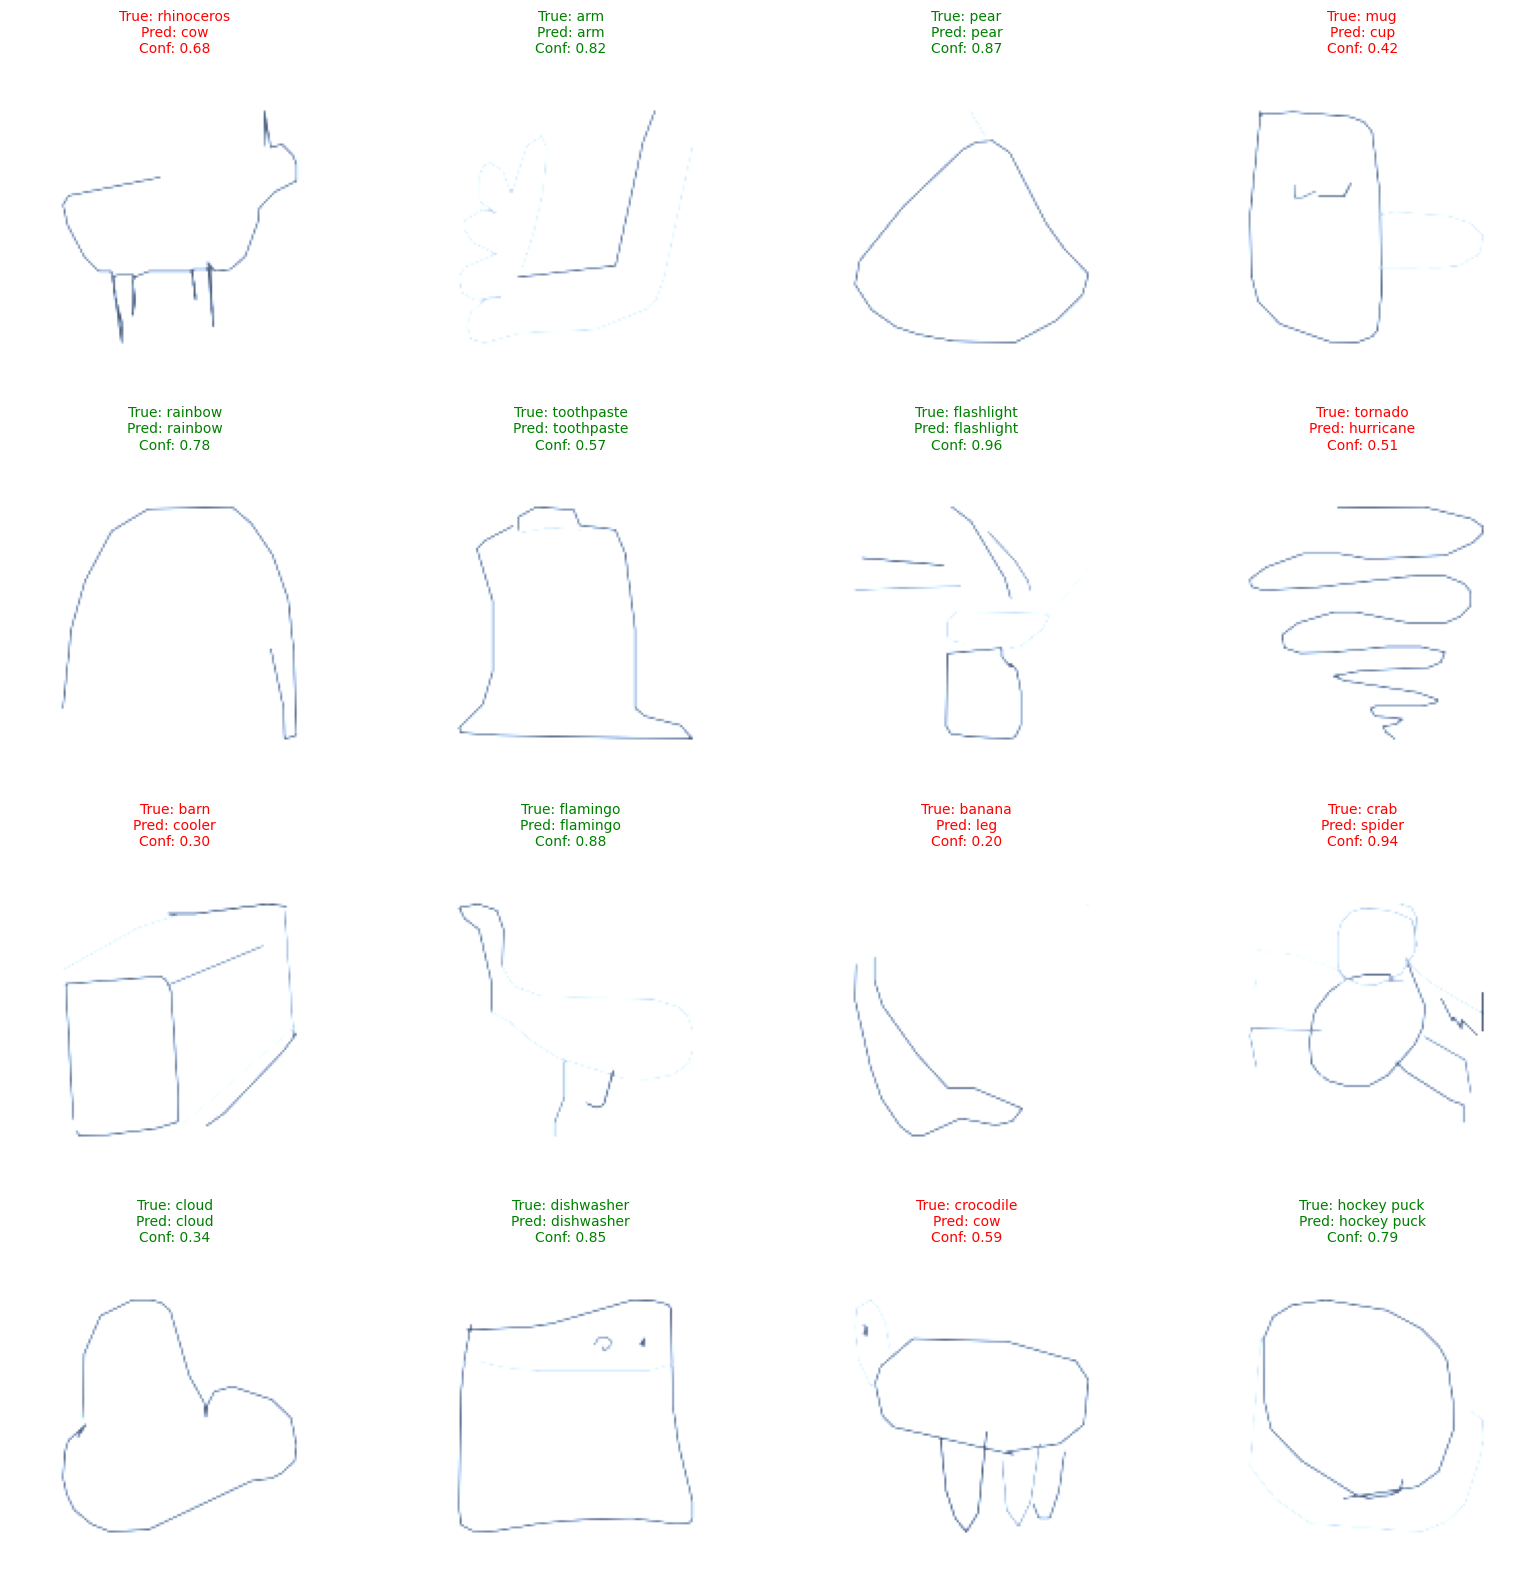

In [54]:
# Visualize predictions on sample test images
def visualize_predictions(model, test_dataset, idx_to_label, num_samples=16, device=device):
    """Visualize model predictions on test images"""
    model.eval()
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()
    
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, true_label = test_dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)
            
            output = model(img_tensor)
            probs = torch.softmax(output, dim=1)
            pred_prob, pred_label = torch.max(probs, 1)
            
            # Denormalize for display
            img_display = img.permute(1, 2, 0).cpu().numpy()
            img_display = (img_display * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
            img_display = np.clip(img_display, 0, 1)
            
            true_label_name = idx_to_label[true_label]
            pred_label_name = idx_to_label[pred_label.item()]
            confidence = pred_prob.item()
            
            axes[i].imshow(img_display)
            color = 'green' if true_label == pred_label.item() else 'red'
            axes[i].set_title(f'True: {true_label_name}\nPred: {pred_label_name}\nConf: {confidence:.2f}', 
                             color=color, fontsize=10)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataset, idx_to_label, num_samples=16, device=device)


## 8. Save Model and Labels


In [55]:
# Save the final model
torch.save(model.state_dict(), 'doodle_recognition_model_pytorch.pth')
print("Model saved as 'doodle_recognition_model_pytorch.pth'")

# Save label mappings
import json
with open('label_mappings_pytorch.json', 'w') as f:
    json.dump({
        'label_to_idx': label_to_idx,
        'idx_to_label': idx_to_label
    }, f, indent=2)
print("Label mappings saved as 'label_mappings_pytorch.json'")

# Save model info
model_info = {
    'img_size': IMG_SIZE,
    'num_classes': NUM_CLASSES,
    'batch_size': BATCH_SIZE,
    'test_accuracy': float(test_accuracy),
    'test_top3_accuracy': float(test_top3_accuracy),
    'model_architecture': 'DoodleCNN'
}

with open('model_info_pytorch.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("Model info saved as 'model_info_pytorch.json'")


Model saved as 'doodle_recognition_model_pytorch.pth'
Label mappings saved as 'label_mappings_pytorch.json'
Model info saved as 'model_info_pytorch.json'


## 9. Inference Function

Use this function to predict doodles from new images.


In [56]:
def predict_doodle(image_path, model, idx_to_label, img_size=IMG_SIZE, top_k=5, device=device):
    """
    Predict doodle category from an image file
    
    Args:
        image_path: Path to image file
        model: Trained PyTorch model
        idx_to_label: Dictionary mapping indices to labels
        img_size: Target image size
        top_k: Number of top predictions to return
        device: Device to run inference on
    
    Returns:
        List of (label, confidence) tuples
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    
    # Apply same transform as validation/test
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
    
    # Get top k predictions
    top_probs, top_indices = torch.topk(probs, top_k)
    top_predictions = [
        (idx_to_label[idx.item()], float(top_probs[0][i].item()))
        for i, idx in enumerate(top_indices[0])
    ]
    
    return top_predictions

# Example usage
print("Example prediction:")
sample_image = list(Path('doodles/doodle/cat').glob('*.png'))[0]
predictions = predict_doodle(sample_image, model, idx_to_label, top_k=5, device=device)
print(f"\nImage: {sample_image}")
for label, confidence in predictions:
    print(f"  {label}: {confidence:.4f}")


Example prediction:

Image: doodles/doodle/cat/5040366845689856.png
  cat: 0.9468
  tiger: 0.0058
  rabbit: 0.0026
  pool: 0.0021
  dog: 0.0015
